# **Thermodynamics Group Project**

## **Column Pressure Optimization: A Modeling and Cost Analysis Approach**

### Arya Rane.

# Table of contents

| Section | Link |
|---------|------|
| Libraries | [Go](#Importing-all-the-necessary-libraries-for-solving-plotting-and-data-handling) |
| Data | [Go](#Data) |
| Model used | [Go](#NRTL-model) |
| Material Balance | [Go](#Material-balance) |
| Minimum and operating reflux ratio | [Go](##Pinch-point) |
| Total stages | [Go](##Number-of-stages) |
| Energy Balance | [Go](##Energy-Balance-of-Column-internal-and-external-flow-rates-,-both-duties) |
| Interpolation | [Go](##2D-interpolation-and-data-extraction-for-packing) |
| Column design and costs | [Go](##Column-specification-&-packings---design-and-costs) |
| Reboiler Cost | [Go](##Reboiler-costing) |
| Condesor Cost | [Go](##Condensor-costing) |
| Total Cost | [Go](##Total-costing) |
| Optimizing Cost | [Go](##Optimizing-column-cost) |

## Importing all the necessary libraries for solving plotting and data handling

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve, curve_fit
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from typing import Callable, Iterable
from google.colab import files
import math
from scipy.optimize import minimize_scalar

In [ ]:
import scipy as sp
import pandas as pd
import polars as pl
import scipy.optimize as spopt
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from typing import Dict
from dataclasses import dataclass

## Data

#### Data obtained from literature and data from problem statement

In [ ]:
# Experimental data
x1 = np.array([0.052,0.095,0.192,0.305,0.403,0.481,0.606,0.706,0.807,0.896])
y1 = np.array([0.120,0.206,0.367,0.510,0.611,0.682,0.781,0.849,0.904,0.951])

P_exp = np.array([225.3,239.9,268.5,302.7,331.7,355.2,393.2,423.6,454.1,481.4])

P_exp *= 1.01325 / 760

Temp_exp = 45 + 273.15  # K

#### computing from experimental data the thermodynamic values γ1 , γ2 and excess G/RT



In [ ]:
P1sat = lambda T: 10**(4.42448 - 1312.253/(T - 32.445))
P2sat = lambda T: 10**(4.27873 - 1355.374/(T - 37.853))

# compute experimental GE/RT from given P (bar) and T
lngamma_1 = np.log(P_exp * y1 / (x1 * P1sat(Temp_exp)))
lngamma_2 = np.log(P_exp * (1-y1) / ((1-x1) * P2sat(Temp_exp)))
GE_RT_exp = x1 * lngamma_1 + (1-x1) * lngamma_2

## NRTL model

#### model fitting to obtain fitted parameters

In [ ]:
#Model
def NRTL(x, tau21, tau12, alpha):
    x1v = np.asarray(x)
    x2v = 1.0 - x1v
    G12 = np.exp(-alpha * tau12)
    G21 = np.exp(-alpha * tau21)
    GE_RT = x1v * x2v * (G21 * tau21 / (x1v + x2v * G21) + G12 * tau12 / (x2v + x1v * G12))
    return GE_RT

# Actual Fitting
p0 = [0.1, 0.3,0.3]  # initial: alpha, tau21, tau12
params, pcov = curve_fit(NRTL, x1, GE_RT_exp, p0, maxfev=10000)
t21_fit, t12_fit, a = params
print("fitted params (a, tau21@Texp, tau12@Texp) =", np.round([a, t21_fit, t12_fit],5))


fitted params (a, tau21@Texp, tau12@Texp) = [11.29188  0.25548  0.18842]


In [ ]:
b = -a
b

np.float64(-11.291884934310913)

#### using emperical relations, formulating function with Temperature (T) as variable

In [ ]:
DU21 = t21_fit * Temp_exp
DU12 = t12_fit * Temp_exp

tau21_T = lambda T: DU21 / T
tau12_T = lambda T: DU12 / T

# Gij(T)
G12_T = lambda T: np.exp(b * tau12_T(T))
G21_T = lambda T: np.exp(b * tau21_T(T))

In [ ]:
eps = 1e-15
x = lambda x: np.clip(x, eps, 1-eps)

In [ ]:
gamma_1 = lambda x, T: np.exp((1-x)**2 * (tau21_T(T) * (G21_T(T) / (x + (1-x) * G21_T(T)))**2 + tau12_T(T) * G12_T(T) / ((1-x) + x * G12_T(T))**2))

gamma_2 = lambda x, T: np.exp(x**2 * (tau21_T(T) * G21_T(T) / (x + (1-x) * G21_T(T))**2 + tau12_T(T) * (G12_T(T) / ((1-x) + x * G12_T(T)))**2))

In [ ]:
P_T = lambda x, T: x * P1sat(T) * gamma_1(x, T) + (1-x) * P2sat(T) * gamma_2(x, T)
# Expresion of Pressure at a stage (bcz - x @ T) which should be equal to operating pressure
Prange = np.arange(.30000, .91000, .01) # Bar

In [ ]:
def y_equm(x1, Pop, Tguess=Temp_exp):
    sol = fsolve(lambda T: P_T(x1, T) - Pop, Tguess)
    Tsol = sol[0]
    y1 = x1 * gamma_1(x1, Tsol) * P1sat(Tsol) / Pop
    return y1, Tsol

The further loop has to include `NRTL` `tau` & `G`



`P_T` is the pressure which is our control variable which we willl change to get the optimal pressure by minimizing the annualized costs \\
`y_equm` is the function of equilibrium Curve

## Operating & feed conditions

In [ ]:
x_f = 0.5
F = 100 * (x_f * 58.08 + (1 - x_f) * 41.05)
q = 1
x_D = 0.99
x_B = 0.0001

## Material balance

In [ ]:
def materialBalance(
    F: float, # Feed flow rate
    x_f: float, # Feed composition
    D: float = None, # Distillate flow rate
    x_D: float = None, # Distillate Composition
    B: float = None, # Bottoms flow rate
    x_B: float = None, # Bottoms Composition
    *,
    tol: float = 1e-12
)-> dict:

    keys    = ['D','x_D','B','x_B']
    values  = [D, x_D, B, x_B]
    known   = {k: (v is not None) for k, v in zip(keys, values)}
    n_known = sum(known.values())


    if not (2 <= n_known <= 4):
        raise ValueError("Must provide exactly two of D, x_D, B, x_B or both compositions x_D & x_B.")
    if known['D'] and known['B'] and not (known['x_D'] and known['x_B']):
        raise ValueError("Provide only one flow (D or B), not both, unless both compositions are given.")

    # Solve cases ...
    if known['D'] and known['x_D']:
        B_calc = F - D
        x_B_calc = (F * x_f - D * x_D) / B_calc
        result = {'D': D, 'x_D': x_D, 'B': B_calc, 'x_B': x_B_calc}
    elif known['B'] and known['x_B']:
        D_calc = F - B
        x_D_calc = (F * x_f - B * x_B) / D_calc
        result = {'D': D_calc, 'x_D': x_D_calc, 'B': B, 'x_B': x_B}
    elif known['x_D'] and known['x_B']:
        A = np.array([[1.0, 1.0], [x_D, x_B]])
        b = np.array([F, F * x_f])
        D_calc, B_calc = np.linalg.solve(A, b)
        result = {'D': D_calc, 'x_D': x_D, 'B': B_calc, 'x_B': x_B}
    else:
        if known['D'] and known['x_B']:
            B_calc = F - D
            x_D_calc = (F * x_f - B_calc * x_B) / D
            result = {'D': D, 'x_D': x_D_calc, 'B': B_calc, 'x_B': x_B}
        elif known['B'] and known['x_D']:
            D_calc = F - B
            x_B_calc = (F * x_f - D_calc * x_D) / B
            result = {'D': D_calc, 'x_D': x_D, 'B': B, 'x_B': x_B_calc}
        else:
            raise ValueError("Unsupported combination of inputs.")

    if result['D'] < -tol or result['B'] < -tol:
        raise ValueError(
            f"Unphysical negative flow: D={result['D']:.6f}, B={result['B']:.6f}."
        )

    return result

In [ ]:
matBal = materialBalance(F, x_f, x_D=x_D, x_B=x_B)
D   = matBal['D']
x_D = matBal['x_D']
B   = matBal['B']
x_B = matBal['x_B']
print(f"D={D:.5f}, x_D={x_D:.5f}, B={B:.5f}, x_B={x_B:.5f}")

D=2503.03500, x_D=0.99000, B=2453.46500, x_B=0.00010


##  Pinch point

In [ ]:
def intersections(
    P_T,
    Pop,                # Pressure of the entire Column
    q: float,
    x_f: float,
    x_D: float,
    ratio: float = 3,
    tol: float = 1e-12,
) -> dict:

    y_qline = lambda x: x * (q / (q - 1 + tol)) - x_f / (q - 1 + tol)

    T_stage = fsolve(lambda T: Pop - P_T(x_f,T), 300)[0]     # Calc temp

    xq = fsolve(lambda x: y_qline(x) - y_equm(x_f, Pop, T_stage)[0], x0=0.5)[0]

    yq = y_equm(x_f, Pop, T_stage)[0]

    slope = lambda R: yq - ((R / (R + 1)) * xq + x_D / (R + 1))

    Rmin = fsolve(slope, x0=1.0)[0]

    RR = Rmin * 1.2

    top_line = lambda x: (RR * x) / (RR + 1) + x_D / (RR + 1)               # y is output

    x_i = fsolve(lambda x: top_line(x) - y_qline(x), x0=0.5)[0]

    y_i = top_line(x_i)

    bottom_line = lambda y: (y - y_i) * (x_B - x_i) / (x_B-y_i) + x_i       # x is output

    return {
        'xq': xq,
        'yq': yq,
        'Rmin': Rmin,
        'RR': RR,
        'x_i': x_i,
        'y_i': y_i,
    }

In [ ]:
inter = intersections(P_T,1.01325,q , x_f , x_D)
xq = inter['xq']
yq = inter['yq']
Rmin = inter['Rmin']
RR = inter['RR']
x_i = inter['x_i']
y_i = inter['y_i']
print(f"xq = {xq:.4f},yq ={yq:.4f},Rmin = {Rmin:.4f},RR = {RR:.4f},xi = {x_i:.4f},yi = {y_i:.4f}")

xq = 0.5000,yq =0.6996,Rmin = 1.4549,RR = 1.7459,xi = 0.5000,yi = 0.6784


## Number of stages

In [ ]:
def stages(
    x_B: float,
    x_D: float,
    x_i: float,
    y_i: float,
    Pop: float
):

    # (x_D, y_d) vs (x_i, y_i)
    top_line = lambda y: (y - y_i) * (x_D - x_i) / (x_D - y_i) + x_i
    # (x_B, y_B) vs (x_i, y_i)
    bottom_line = lambda y: (y - y_i) * (x_B - x_i) / (x_B - y_i) + x_i

    x, y = x_B, x_B
    xs, ys = [x], [y]
    xstage, ystage, Tstage = [x], [y], []
    total = rect = strip = 0

    # apped toxs and ys twice
    while x < x_D:
        y, T = (y_equm(x, Pop))
        ys.append(y)
        xs.append(x)
        Tstage.append(T)
        Tstage.append(T)
        if y < y_i:
            x = float(bottom_line(y))
            ys.append(y)
            strip += 1
        else:
            if y > x_D:
                x = y
                ys.append(y)
                rect += 1

            else:
                x = float(top_line(y))
                ys.append(y)
                rect += 1
        xs.append(x)

        total += 1

    Nmin = 0
    x, y = x_B, x_B
    while x < x_D:
        y, T = (y_equm(x, Pop))
        x = y
        Nmin += 1

    return pd.Series({ "xs":xs, "ys" :ys,"Tstage":Tstage, "total":total, "rect":rect, "strip":strip, "Nmin":Nmin})

In [ ]:
Nstages = stages(x_B, x_D, x_i, y_i, 1)
xs = Nstages['xs']
ys = Nstages['ys']
Tstage = Nstages['Tstage']
total = Nstages['total']
rect = Nstages['rect']
strip = Nstages['strip']
Nmin = Nstages['Nmin']
print(f"total = {total}, rect = {rect}, strip = {strip}, Nmin = {Nmin}")

total = 30, rect = 13, strip = 17, Nmin = 16


In [ ]:
Tstage[-1],Tstage[0]  # Bottom top approach: Distillate temp, bottoms temp

(np.float64(329.2871466360056), np.float64(354.61707138038093))

In [ ]:
T_cw_in, T_cw_out = 15, 15.01       # Abundant water so the temperature barely changes

## Energy Balance of Column - internal and external flow rates, both duties

In [ ]:
@dataclass
class ColumnEnergyParams:
    F: float               # Feed flow rate (kg/hr)
    D: float               # Distillate flow rate (kg/hr)
    B: float               # Bottoms flow rate (kg/hr)
    q: float               # Thermal condition of feed (0: saturated vapor, 1: saturated liquid)
    R: float               # Reflux ratio
    molwt_BT: float = 58 * x_f + (1-x_f) * 41 # MOlecular wt. of Composition of feed approximated everywhere (kg/kmol)

    # Constants
    c_p: float = 2113   # Liquid heat capacity (J/kg.K)... chatgpt
    lam_BT: float = 6.482*10**5     # Latent heat of vaporization of MIxture (J/kg)... chatgpt
    c_p_w: float = 4186 # J/kg.K
    lam_w: float = 2.13e+6    # Latent heat of vaporization of Steam(J/kg)
    T_distill: float = 273.15 + 81.7 # Distillate temperature (K)
    T_feed: float = 273.15 + 94 # Feed temperature (K)
    T_boil: float = 273.15 + 94 # Boiling point of feed (K)
    T_reboil: float = 273.15 + 108  # Reboiler temp (K)
    T_cw_in: float = T_cw_in
    T_cw_out: float = T_cw_out   # Cooling water temperature rise (K)
    steam_cost: float = 2000   # Rs/ton
    cw_cost: float = 10e-12    # Rs/ton

In [ ]:
def compute_energy(params) -> pd.Series:
    # 1. Reflux and vapor flows
    L = params.R * params.D
    V = L + params.D        # Vapor flowrate from reboiler
    R = params.R
    B = params.B
    D = params.D
    F = params.F

    dT_cw = ((params.T_distill - params.T_cw_out)-(params.T_distill - params.T_cw_in)) / np.log((params.T_distill - params.T_cw_out)/(params.T_distill - params.T_cw_in))

    Vflow  = V + F * q      # kg/hr

    lam_BT = 1.13e+6 * (1 - params.T_distill / 545)**0.4246  # J/kg
    # Heat and Reboiler Energy and Power
    H_sens = F * params.c_p * (params.T_reboil - params.T_feed)  # J/hr

    H_feed = F * params.lam_BT * params.q  # J/hr

    H_latent = (Vflow - B) * params.lam_BT   # J/hr

    reboiler_duty = (H_sens + H_latent - H_feed + L * params.lam_BT) # Reboiler Duty J/hr

    m_s = reboiler_duty / params.lam_w  # Steam MAss Flow Rate kg/hr

    lam_BT = 67881.2 * (508.7 - params.T_distill)**0.386 # J/kg
    # Condenser Duty and Energy and Power
    condenser_duty = Vflow * params.lam_BT    # J/hr

    m_cw = condenser_duty / (params.c_p_w * dT_cw)    # Water mass flow rate kg/hr

    # Costs
    cost_steam = (m_s / 1000) * params.steam_cost  # Rs/hr
    cost_cw = (m_cw / 1000) * params.cw_cost   # Rs/hr

    return pd.Series({
        "Reflux flow (kg/hr)": L,
        "Vapor flow (kg/hr)": V,
        "Feed flow (kg/hr)": F,
        "Bottoms flow (kg/hr)": B,
        "Distillate flow (kg/hr)": D,
        "Reflux": R,
        "Boilup rate (kg/hr)": Vflow - B,
        "Vapour Flow Rate (kg/hr)": Vflow,
        "Steam flow (kg/hr)": m_s,
        "Cooling water flow (kg/hr)": m_cw,
        "Reboiler Duty (kW)": reboiler_duty/3600000,
        "Condenser duty (kW)": condenser_duty/3600000,
        "Steam cost (Rs/hr)": cost_steam,
        "CW cost (Rs/hr)": cost_cw
    })

In [ ]:
params = ColumnEnergyParams(F=F, D=D, B=B, R=RR, q=q)
energy = compute_energy(params)
print(energy)

Reflux flow (kg/hr)           4.370005e+03
Vapor flow (kg/hr)            6.873040e+03
Feed flow (kg/hr)             4.956500e+03
Bottoms flow (kg/hr)          2.453465e+03
Distillate flow (kg/hr)       2.503035e+03
Reflux                        1.745883e+00
Boilup rate (kg/hr)           9.376075e+03
Vapour Flow Rate (kg/hr)      1.182954e+04
Steam flow (kg/hr)            2.743676e+03
Cooling water flow (kg/hr)    5.390100e+03
Reboiler Duty (kW)            1.623341e+03
Condenser duty (kW)           2.129974e+03
Steam cost (Rs/hr)            5.487351e+03
CW cost (Rs/hr)               5.390100e-11
dtype: float64


## 2D interpolation and data extraction for packing


#### calculating suitable value of dP/dz and HETP

In [ ]:
pressures = [50, 100, 400, 960]
dpdz_pattern = "dpdz{P}.csv"
hetp_pattern = "hetp{P}.csv"
def clean(path, names):
    df = pd.read_csv(path, sep=r"\s+", header=None, names=names, dtype=str, engine="python")
    for c in df.columns:
        df[c] = df[c].astype(str).str.replace(",", "", regex=False).str.strip()
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    if df.shape[1] > 1:
        df = df.dropna(how="all")
    else:
        df = df.dropna()
    return df.reset_index(drop=True)

dpdz_data = {}
hetp_data = {}
all_dpdz_points = []
all_F_points_from_hetp = []

for P in pressures:
    df_d = clean(dpdz_pattern.format(P=P), ["F", "dpdz"]).dropna(subset=["F", "dpdz"]).copy()
    df_d["dpdz"] = df_d["dpdz"]
    df_h = clean(hetp_pattern.format(P=P), ["F", "HETP"]).dropna(subset=["F", "HETP"]).copy()
    if df_d.empty:
        raise ValueError(f"No usable numeric rows found in {dpdz_pattern.format(P=P)}")
    if df_h.empty:
        raise ValueError(f"No usable numeric rows found in {hetp_pattern.format(P=P)}")
    dpdz_data[P] = df_d
    hetp_data[P] = df_h
    all_dpdz_points.append(df_d["dpdz"].values)
    all_F_points_from_hetp.append(df_h["F"].values)

dpdz_grid = np.unique(np.concatenate(all_dpdz_points)); dpdz_grid.sort()
F_axis = np.unique(np.concatenate(all_F_points_from_hetp)); F_axis.sort()

if dpdz_grid.size < 2 or F_axis.size < 2:
    raise ValueError("Not enough experimental points to build grids.")

perP_Fmin = {}
perP_Fmax = {}
for P in pressures:
    dfh = hetp_data[P]
    perP_Fmin[P] = float(dfh["F"].min())
    perP_Fmax[P] = float(dfh["F"].max())

#### using regular grid interpolator

In [ ]:
f_F_funcs = {}
f_hetp_funcs = {}

for P in pressures:
    df_d = dpdz_data[P].sort_values("dpdz").reset_index(drop=True)
    df_h = hetp_data[P].sort_values("F").reset_index(drop=True)
    f_F_funcs[P] = interp1d(df_d["dpdz"].values, df_d["F"].values, kind="linear", fill_value="extrapolate", assume_sorted=True)
    f_hetp_funcs[P] = interp1d(df_h["F"].values, df_h["HETP"].values, kind="linear", fill_value="extrapolate", assume_sorted=True)

F_grid = np.empty((len(dpdz_grid), len(pressures)))
H_grid = np.empty((len(F_axis), len(pressures)))

for j, P in enumerate(pressures):
    F_grid[:, j] = f_F_funcs[P](dpdz_grid)
    F_clamped = np.clip(F_axis, perP_Fmin[P], perP_Fmax[P])
    H_grid[:, j] = f_hetp_funcs[P](F_clamped)

f_F_2d = RegularGridInterpolator((dpdz_grid, pressures), F_grid, bounds_error=False, fill_value=None)
f_hetp_2d = RegularGridInterpolator((F_axis, pressures), H_grid, bounds_error=False, fill_value=None)

def f_F(dpdz_query, P_query):           # use these
    dp = np.asarray(dpdz_query)
    pp = np.asarray(P_query)
    dp_b, pp_b = np.broadcast_arrays(dp, pp)
    pts = np.column_stack([dp_b.ravel(), pp_b.ravel()])
    vals = f_F_2d(pts)
    return vals.reshape(dp_b.shape)

def f_hetp(F_query, P_query):           # use These
    Fq = np.asarray(F_query)
    Pq = np.asarray(P_query)
    F_b, P_b = np.broadcast_arrays(Fq, Pq)
    pts = np.column_stack([F_b.ravel(), P_b.ravel()])
    vals = f_hetp_2d(pts)
    return vals.reshape(F_b.shape)


#### Interpolation curves

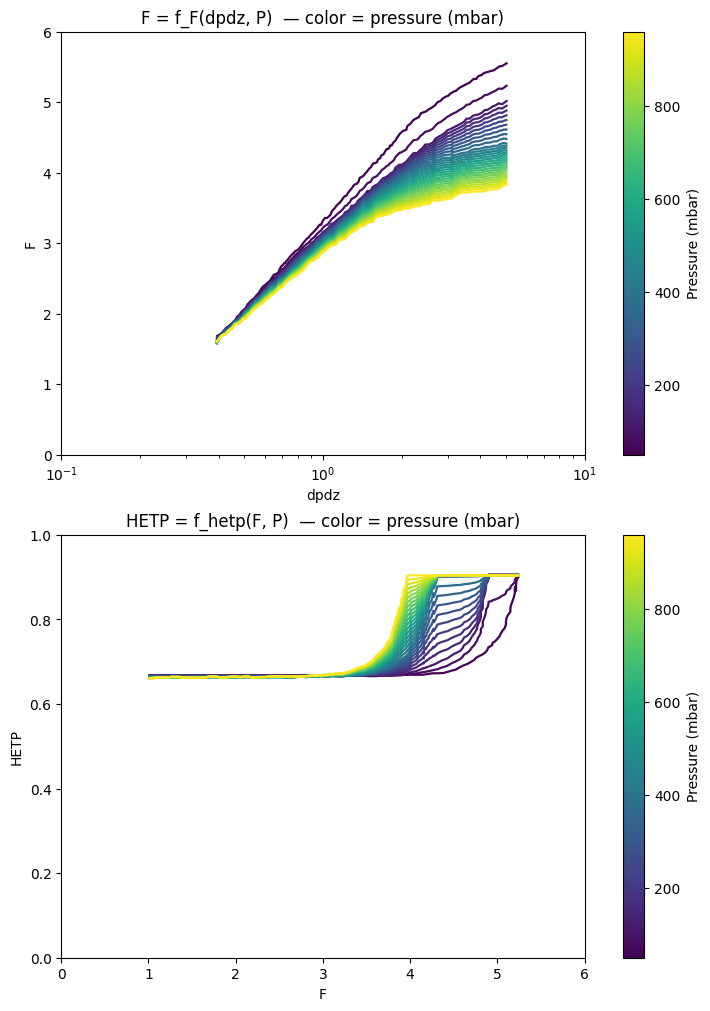

In [ ]:
Pmin, Pmax = min(pressures) , max(pressures)
P_samples = np.linspace(Pmin, Pmax, 30)
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(Pmin, Pmax)

fig, axes = plt.subplots(2, 1, figsize=(7, 10), constrained_layout=True)

dpdz_plot = dpdz_grid[dpdz_grid > 0]
segments = []
colors = []
for P in P_samples:
    Fvals = f_F(dpdz_plot, P)
    pts = np.column_stack([dpdz_plot, Fvals])
    segments.append(pts)
    colors.append(cmap(norm(P)))

lc = LineCollection(segments, colors=colors, linewidths=1.6)
axes[0].add_collection(lc)
axes[0].set_xscale('log')
axes[0].set_xlim(0.1, 10)
axes[0].set_ylim(0.0, 6.0)
axes[0].set_xlabel("dpdz")
axes[0].set_ylabel("F")
axes[0].set_title("F = f_F(dpdz, P)  — color = pressure (mbar)")
fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes[0], orientation="vertical").set_label("Pressure (mbar)")

segments = []
colors = []
for P in P_samples:
    Hvals = f_hetp(F_axis, P)
    pts = np.column_stack([F_axis, Hvals])
    segments.append(pts)
    colors.append(cmap(norm(P)))

lc2 = LineCollection(segments, colors=colors, linewidths=1.6)
axes[1].add_collection(lc2)
axes[1].set_xlim(0.0, 6.0)
axes[1].set_ylim(0.0, 1.0)
axes[1].set_xlabel("F")
axes[1].set_ylabel("HETP")
axes[1].set_title("HETP = f_hetp(F, P)  — color = pressure (mbar)")
fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes[1], orientation="vertical").set_label("Pressure (mbar)")

plt.show()


## Column specification & packings  - design and costs

#### function for column area

In [ ]:
def area(Vflow, rho_v=2.0, vmax=1.0, eff=0.85):
    # Vflow: vapor flowrate [kg/h]
    # rho_v: vapor density [kg/m3]
    V = Vflow / (rho_v * 3600)          # m3/s volumetric flow
    A = V / (eff * vmax)                # cross-sectional area
    D = (4*A/np.pi)**0.5                # diameter
    return A, D


#### function for height of column

In [ ]:
def height(Nstages, f_F, f_hetp, P,
                  dpdz=0.45,
                  n_distributors=1,
                  h_distributor=0.6,
                  h_top=1.0,
                  h_bottom=0.5,
                  h_misc=0.5        # Man hole or space above or below the distributor
                  ):


    F = f_F(dpdz, P)
    hetp = f_hetp(F, P)

    H_packing = hetp * Nstages["total"] * 1.1 # factor to account for the graph errors and data extraction if any - analysis for the value not calculated - why 1.1 is an assumption nothing to cite in particular

    H_distributors = n_distributors * h_distributor
    H_allowances = h_top + h_bottom + h_misc

    H_column = H_packing + H_distributors + H_allowances

    return {
        "Packing height (m)": H_packing,
        "Total column height (m)": H_column
    }

#### Function for cost of packings

In [ ]:
def pack_costs(Height, Area,
               cost_per_m3=50000,       # Rs/m3
               n_distributors=1,
               distributor_cost_each=500000 # Rs/m2 of CSA
               ):
    pack_vol = Area * Height
    return pack_vol * cost_per_m3 + n_distributors * distributor_cost_each * Area


#### Function for total column shell costs

In [ ]:
def shell_costs(Height, Diameter, Pop,
                cost_per_kg=450,
                rho_ss=8000,
                f=1.4e8,   # Pa, allowable stress for SS316
                e=0.9,     # weld efficiency
                c=0.002):  # corrosion allowance (m)

    P = abs(1.01325 - Pop)

    # Thickness from thin-cylinder formula
    t_calc = (P * Diameter) / (2 * f * e) + c       # C&R

    t_min = 0.005 if Diameter <= 1 else 0.007       # C&R

    t = max(t_calc, t_min)

    shell_vol = np.pi * Diameter * Height * t

    m_shell = shell_vol * rho_ss

    base_cost = m_shell * cost_per_kg

    fabrication_cost = 1.5 * base_cost


    return {
        "Thickness (m)": t,
        "Shell mass (kg)": m_shell,
        "Base cost": base_cost,
        "Total cost": fabrication_cost,
    }


#### Function to account for miscellaneous costs

In [ ]:
def miscellaneous_costs(pack_cost, shell_cost):
    return ((pack_cost + shell_cost) * 0.5) # Transportation and miscellaneous cost 50% of fabrication and material costs + PI

## Condenser costing

In [ ]:
def condenser_cost(           # C&R
    condenser_duty_kW,        # condenser duty (kW)
    T_distill_K,              # distillate (vapour) saturation temperature (K)
    U_overall_W_m2K = 500,    # overall heat-transfer coefficient (W/m2.K)
    # coolant (fixed by plant; treated as constants but overridable)
    coolant_in_C = T_cw_in,      # coolant inlet temperature
    coolant_out_C = T_cw_out,    # coolant outlet temperature

    tube_outer_diameter_m = 0.025,  # tube outside diameter (m)
    tube_inner_diameter_m = 0.021,  # tube inside diameter (m)
    tube_length_m = 3.66,           # tube active length (m)
    pitch_factor = 1.5,             # pitch = pitch_factor * do
    pitch_type = "vertical",
    tube_arrangement = "vertical_tubes",
    kL_W_mK = None,           # condensate thermal conductivity (W/m.K)
    rho_L_kg_m3 = None,       # condensate density (kg/m3)
    rho_v_kg_m3 = None,       # vapour density (kg/m3)
    mu_L_Ns_m2 = None,        # condensate dynamic viscosity (Ns/m2)
    latent_kJkg = None,       # latent heat of condensation (kJ/kg)
    # bundle / bank correction
    kernel_index = 1/6.0,     # use Kern index 1/6 recommended by C&R for tube banks
    Nr_rows = None,           # vertical rows in bank

    cost_per_m2_inr = 500000.0,
    fab_multiplier = 1.0,
    installation_fraction = 0,

    Nt_min_guard = 1,
    tol = 1e-6
):

    Tsat_C = float(T_distill_K) - 273.15
    t1 = float(coolant_in_C)
    t2 = float(coolant_out_C)

    delta1 = Tsat_C - t1
    delta2 = Tsat_C - t12_fit
    if delta1 <= 0 or delta2 <= 0:
        delta1 = max(delta1, 1e-6)
        delta2 = max(delta2, 1e-6)
    if abs(delta1 - delta2) < 1e-9:
        deltaT_lm = delta1
    else:
        deltaT_lm = (delta1 - delta2) / math.log(delta1 / delta2)

    Q_W = float(condenser_duty_kW) * 1000.0

    # area from Q = U * A * LMTD  so A = Q / (U * LMTD)
    A_m2 = Q_W / max(U_overall_W_m2K * deltaT_lm, 1e-12)

    # estimate per tube outside area and tube count
    A_per_tube = math.pi * tube_outer_diameter_m * tube_length_m
    Nt = max(int(math.ceil(A_m2 / A_per_tube)), Nt_min_guard)

    pitch = pitch_factor * tube_outer_diameter_m
    cols = math.ceil(math.sqrt(Nt))
    bundle_d_m = cols * pitch

    shell_to_bundle = 1.4
    shell_d_m = shell_to_bundle * bundle_d_m


    condensate_mass_kg_s = None
    if latent_kJkg is not None and latent_kJkg > 0:
        latent_Jkg = latent_kJkg * 1000.0
        condensate_mass_kg_s = Q_W / latent_Jkg

    hc_single_W_m2K = None
    hc_bundle_W_m2K = None
    if all(v is not None for v in (kL_W_mK, rho_L_kg_m3, rho_v_kg_m3, mu_L_Ns_m2)):
        g = 9.81
        if condensate_mass_kg_s is not None:
            o_v = (condensate_mass_kg_s / max(Nt, 1)) / max(tube_length_m, 1e-9)
        else:
            o_v = 1e-6
        hc_single_W_m2K = 0.926 * kL_W_mK * (( (rho_L_kg_m3 * (rho_L_kg_m3 - rho_v_kg_m3) * g) / (mu_L_Ns_m2 * o_v) ) ** (1.0/3.0))
        # bundle correction per Kernindex 1/6
        if Nr_rows is None:
            Nr = max(1.0, 0.67 * cols)
        else:
            Nr = max(1.0, float(Nr_rows))
        hc_bundle_W_m2K = hc_single_W_m2K * (Nr ** (1.0/6.0))

    flooding_margin = None
    if condensate_mass_kg_s is not None and rho_L_kg_m3 is not None and rho_v_kg_m3 is not None:
        uv = None
        uL = None
        try:
            total_tube_area = Nt * (math.pi * (tube_inner_diameter_m ** 2) / 4.0)
            uv = (condensate_mass_kg_s) / max(total_tube_area * rho_v_kg_m3, 1e-12)
            uL = (condensate_mass_kg_s) / max(total_tube_area * rho_L_kg_m3, 1e-12)
            lhs = ( (uv ** 0.5) * (rho_v_kg_m3 ** 0.25) + (uL ** 0.5) * (rho_L_kg_m3 ** 0.25) )
            rhs = 0.6 * ( (g * tube_inner_diameter_m * (rho_L_kg_m3 - rho_v_kg_m3)) ** 0.25 )
            flooding_margin = float(rhs - lhs)
        except Exception:
            flooding_margin = None

    base_cost_inr = A_m2 * cost_per_m2_inr
    fabrication_cost_inr = base_cost_inr * fab_multiplier
    installation_cost_inr = fabrication_cost_inr * installation_fraction
    total_capital_inr = fabrication_cost_inr + installation_cost_inr

    return {
        "Condenser duty kW": float(condenser_duty_kW),
        "Distillate temperature C": float(Tsat_C),
        "Coolant inlet C": float(t1),
        "Coolant outlet C": float(t2),
        "Log mean temperature difference C": float(deltaT_lm),
        "Area m2": float(A_m2),
        "Heat flux W per m2": float(Q_W / max(A_m2, 1e-12)),
        "Number of tubes": int(Nt),
        "Bundle diameter m": float(bundle_d_m),
        "Shell diameter m": float(shell_d_m),
        "Condensate mass kg per s": condensate_mass_kg_s,
        "Total capital": float(base_cost_inr)
    }


## Reboiler cost

In [ ]:
def kettle_reboiler_cost(        # C&R
    Q_kW,                        # heat duty (kW)
    Tboil_C,                # boiling temperature
    Tsteam_superheat=25.0,       # steam above boiling
    do_m=0.03,                   # tube outer diameter (m)
    tube_len_m=4.8,              # active tube length per tube (m)
    pitch_factor=1.5,            # pitch = pitch_factor * do_m
    U_guess_W_m2K=500.0,
    h_steam_W_m2K=8000.0,
    fouling_shell_W_m2K=5000.0,
    fouling_liq_W_m2K=10000.0,
    wall_thk_m=0.025,
    k_wall_W_mK=55.0,
    Kb=0.44,
    Nt_min_guard=1,
    max_iter=30,
    tol=1e-3,
    cost_per_m2_inr: float = 500000.0,   # cost in INR per m^2
    fab_multiplier: float = 1.0,
    installation_fraction: float = 0,
    steel_density_kg_m3=7850.0
):
    Tsteam_C = Tboil_C + Tsteam_superheat
    deltaT = Tsteam_C - Tboil_C
    Q_W = float(Q_kW) * 1000.0

    A_m2 = Q_W / (U_guess_W_m2K * deltaT)
    U_prev = U_guess_W_m2K

    C_ms = 2.22
    n_ms = 0.70

    for _ in range(max_iter):
        q_flux_W_m2 = Q_W / A_m2
        h_nb = C_ms * (q_flux_W_m2 ** n_ms)
        R_liq = 1.0 / h_nb if h_nb > 0 else 1e12
        R_f_liq = 1.0 / fouling_liq_W_m2K if fouling_liq_W_m2K > 0 else 0.0
        R_wall = wall_thk_m / k_wall_W_mK
        R_f_steam = 1.0 / fouling_shell_W_m2K if fouling_shell_W_m2K > 0 else 0.0
        R_steam = 1.0 / h_steam_W_m2K if h_steam_W_m2K > 0 else 1e12
        R_total = R_liq + R_f_liq + R_wall + R_f_steam + R_steam
        U_new = 1.0 / R_total if R_total > 0 else 0.0
        A_new = Q_W / (U_new * deltaT) if U_new > 0 else A_m2
        if abs(A_new - A_m2) / max(A_m2, 1e-6) < tol and abs(U_new - U_prev) / max(U_prev, 1e-6) < tol:
            A_m2 = A_new
            U_prev = U_new
            h_nb_final = h_nb
            q_flux_final = q_flux_W_m2
            break
        A_m2 = A_new
        U_prev = U_new
        h_nb_final = h_nb
        q_flux_final = q_flux_W_m2

    A_per_tube = math.pi * do_m * tube_len_m
    Nt = max(int(math.ceil(A_m2 / A_per_tube)), Nt_min_guard)
    pitch = pitch_factor * do_m
    cols = math.ceil(math.sqrt(Nt))
    bundle_d_m = cols * pitch

    if q_flux_final <= 25000.0:
        shell_to_bundle = 1.2
    elif q_flux_final <= 40000.0:
        shell_to_bundle = 1.4
    else:
        shell_to_bundle = 1.7
    shell_d_m = shell_to_bundle * bundle_d_m

    sigma_N_m = 0.0097
    g = 9.81
    rho_l = 550.0
    rho_v = 12.6
    pt_m = pitch
    qcb_W_m2 = Kb * 12.74 * (pt_m / do_m) * (g * sigma_N_m * (rho_l - rho_v)) ** 0.25 / float(Nt)
    allowable_qcb_W_m2 = 0.7 * qcb_W_m2

    tube_wall = wall_thk_m
    di_m = max(0.0, do_m - 2.0 * tube_wall)
    tube_cross_area = math.pi * (((do_m / 2.0) ** 2) - ((di_m / 2.0) ** 2))
    tubes_total_length = Nt * tube_len_m
    tubes_vol_m3 = tube_cross_area * tubes_total_length
    tubes_mass_kg = tubes_vol_m3 * steel_density_kg_m3

    shell_area_side = math.pi * shell_d_m * tube_len_m
    shell_vol_m3 = shell_area_side * wall_thk_m
    shell_mass_kg = shell_vol_m3 * steel_density_kg_m3

    material_mass_kg = tubes_mass_kg + shell_mass_kg

    base_cost_inr = A_m2 * cost_per_m2_inr
    fabrication_cost_inr = base_cost_inr * fab_multiplier
    installation_cost_inr = fabrication_cost_inr * installation_fraction
    total_capital_inr = fabrication_cost_inr + installation_cost_inr

    return {
        "Heat duty kW": float(Q_kW),
        "Area m2": A_m2,
        "Heat flux W per m2": q_flux_final,
        "Boiling coefficient W per m2K": h_nb_final,
        "Overall U W/m2K": U_prev,
        "Number of tubes": Nt,
        "Bundle diameter m": bundle_d_m,
        "Shell diameter m": shell_d_m,
        "Critical heat flux W/m2": qcb_W_m2,
        "Total capital": total_capital_inr
    }

## __Total Costing__

### NRTL fitting
`x`,`y`,`P_exp`,`Temp_exp`@from literature \\
`a=0.4`@literature \\
`NRTL(x, tau21, tau12, alpha=a)` \\
`P1sat(T), P2sat(T)`
fit: `t21_fit`, `t12_fit` \\
`tau21_T(T), tau12_T(T)` \\
`G12_T(T), G21_T(T)` \\
`gamma_1(x, t), gamma_2(x, t)`
`P_T(x, t)`

### $y_{equilibrium}$
`y_equm, Tstage = y_equm(x1, Pop, Tguess)`

### MEBC and basic Thermodynamics
`matBal = materialBalance(F, x_f, x_D=x_D, x_B=x_B, tol=1e-8)` \\
Result: `D, x_D, B, x_B = matBal`

`inter = intersections(q , x_f, x_D, Pop, tol=1e-10)` \\
Result: `xq, yq, Rmin, RR, x_i, y_i = inter`

\\
### Column Specifications and Design

`Nstages = stages(x_B, x_D, x_i, y_i, Pop)` \\
Result: `xs(array), ys(array), Tstage(array), total, rect, strip = Nstages` \\

`stage_data = stage_P(stages, intersections, q, x_f, x_D, Pop)` \\
Result: `Pop, Nstages, x_i, y_i`



\\
### Operational Costs
`params = ColumnEnergyParams(F=F, D=D, B=B, q=q, R=RR)` # Class \\
`energy = compute_energy(params)` \\
Results: `L, V, F, D, R, BoilupRate, VapFlowRate, SteamFlow, cwFlow, ReboilHD,CondHD, SteamCost, cwCost` \\

### Webplotdigitizer
`f_F960, f_hetp960,f_F400, f_hetp400,f_F100, f_hetp100,f_F, f_hetp`


### Capital Costs
`Area , Diameter = area(vmax, param, MW)` \\

`Height = height(Nstages)` \\
 \\

`pack_costs = pack_costs(Height,Area)` \\

`shell_costs = shell_costs(Height, Diameter)` \\

`miscellaneous(pack_costs, shell_costs)` \\

`condenser_costs = condenser_cost(energy)["Costs"]` \\

`reboiler_cost(energy)`





#### Tabular representation for all costs

In [ ]:
def total_costs(
    y_equm: Callable,             # VLE -> y
    materialBalance: Callable,
    intersections: Callable,
    stages: Callable,
    compute_energy: Callable,
    ColumnEnergyParams,
    f_F: Callable,
    f_hetp: Callable,
    area: Callable,
    height: Callable,
    pack_costs: Callable,
    shell_costs: Callable,
    miscellaneous: Callable,
    condenser_cost: Callable,
    kettle_reboiler_cost: Callable,
    Prange, # Operation Pressure of entire Column
    F: float = None, # Feed flow rate
    x_f: float = None, # Feed composition
    D: float = None, # Distillate flow rate
    x_D: float = None, # Distillate Composition
    B: float = None, # Bottoms flow rate
    x_B: float = None, # Bottoms Composition
    q: float = 1, # Thermal condition of feed (0: saturated vapor, 1: saturated liquid)
)-> pd.DataFrame:

    matBal = materialBalance(F=F, x_f=x_f, x_D=x_D, x_B=x_B)
    D = matBal['D']
    x_D = matBal['x_D']
    B = matBal['B']
    x_B = matBal['x_B']

    rows = []

    for Pop in Prange:

        inter = intersections(P_T, Pop, q, x_f, x_D)
        Rmin = inter["Rmin"]
        R = inter['RR']
        x_i = inter['x_i']
        y_i = inter['y_i']

        Nstages = stages(x_B, x_D, x_i, y_i, Pop)
        Tstage = Nstages['Tstage']
        total = Nstages['total']
        rect = Nstages['rect']
        strip = Nstages['strip']
        Nmin = Nstages['Nmin']
        xs = Nstages['xs']
        ys = Nstages['ys']

        params = ColumnEnergyParams(F=F, D=D, B=B, q=q, R=R,
                        T_distill = Tstage[-1], # Distillate temperature (K)
                        T_feed = y_equm(x_f, Pop)[1], # Feed temperature (K)
                        T_boil = y_equm(x_f, Pop)[1], # Boiling point of feed (K)
                        T_reboil = Tstage[0])

        T_distill = Tstage[-1]
        T_reboil = Tstage[0]
        energy = compute_energy(params)

        Vflow = energy["Vapour Flow Rate (kg/hr)"]
        condenser_duty = energy["Condenser duty (kW)"]
        reboiler_duty = energy["Reboiler Duty (kW)"]


        Area, Diameter = area(Vflow)

        Height = height(Nstages,f_F,f_hetp,Pop*1000)["Packing height (m)"]

        FFactor = f_F(0.5,Pop*1000)
        HETP = f_hetp(FFactor,Pop*1000)

        pack = pack_costs(Height, Area)

        shell = shell_costs(Height, Diameter,Pop)["Total cost"]

        miscellaneous = miscellaneous_costs(pack, shell)

        condenser = condenser_cost(condenser_duty, T_distill,500)["Total capital"]

        reboiler = kettle_reboiler_cost(reboiler_duty,Tboil_C = T_reboil)["Total capital"]

        steam_cost = energy["Steam cost (Rs/hr)"]
        cw_cost = energy["CW cost (Rs/hr)"]

        operational_costs = (
            energy["Steam cost (Rs/hr)"] +
            energy["CW cost (Rs/hr)"]
        )

        capital_costs = (pack + shell + miscellaneous + condenser+ reboiler)

        annual_operational_costs = operational_costs * 24 * 366

        total_annualized_costs = annual_operational_costs + 0.2 * capital_costs

        rows.append({
            "Operating Pressure": Pop,
            "Reflux Ratio": R,
            "Rmin": Rmin,
            "Operating Lines intersection": [x_i, y_i],
            "Temperature of Distill": Tstage[-1],
            "Temperature of Bottoms": Tstage[0],
            "Vapour Flow Rate": Vflow,
            "Condenser Duty": condenser_duty,
            "Reboiler Duty": reboiler_duty,
            "Total Stages": total,
            "Rectification Stages": rect,
            "Stripping Stages": strip,
            "Nmin": Nmin,
            "F Factor @ dpdz=0.5": FFactor,
            "HETP": HETP,
            "Area": Area,
            "Diameter": Diameter,
            "Height": Height,
            "Packing Costs": pack,
            "Shell Costs": shell,
            "Miscellaneous Costs": miscellaneous,
            "Condenser Costs": condenser,
            "Reboiler Costs": reboiler,
            "Steam Cost per hour": steam_cost,
            "CW Cost per hour": cw_cost,
            "Operational Costs per Hour": operational_costs,
            "Total Capital Costs": capital_costs,
            "Annual Operational Costs": annual_operational_costs,
            "Total Annualized Costs": total_annualized_costs
        })

    df = pd.DataFrame(rows)
    return df

In [ ]:
df = total_costs(y_equm,             # VLE -> y
    materialBalance,
    intersections,
    stages,
    compute_energy,
    ColumnEnergyParams,
    f_F,
    f_hetp,
    area,
    height,
    pack_costs,
    shell_costs,
    miscellaneous_costs,
    condenser_cost,
    kettle_reboiler_cost,
    Prange, # Operation Pressure of entire Column
    F = 5000,
    x_f = 0.5,
    x_D=0.99, # Distillate Composition
    x_B=0.0001, # Bottoms Composition
    q=1)

In [ ]:
df

,Operating Pressure,Reflux Ratio,Rmin,Operating Lines intersection,Temperature of Distill,Temperature of Bottoms,Vapour Flow Rate,Condenser Duty,Reboiler Duty,Total Stages,...,Shell Costs,Miscellaneous Costs,Condenser Costs,Reboiler Costs,Steam Cost per hour,CW Cost per hour,Operational Costs per Hour,Total Capital Costs,Annual Operational Costs,Total Annualized Costs
0,0.30,1.501258,1.251048,"[0.5000000000006959, 0.6959014311498875]",297.829188,320.122352,11315.682485,2037.451496,1415.713846,28,...,3.731188e+06,3.274411e+06,1.276976e+08,3.797915e+07,4785.511592,6.195466e-11,4785.511592,1.755000e+08,4.203593e+07,7.713593e+07
1,0.31,1.507377,1.256148,"[0.5000000000006954, 0.6954233122276486]",298.605362,320.961992,11331.134312,2040.233684,1421.406425,28,...,3.732957e+06,3.277022e+06,1.215444e+08,3.813187e+07,4804.754113,6.186947e-11,4804.754113,1.695074e+08,4.220496e+07,7.610644e+07
2,0.32,1.513326,1.261105,"[0.500000000000695, 0.6949607681637416]",299.361549,321.779747,11346.154917,2042.938227,1426.940667,28,...,3.734652e+06,3.279542e+06,1.161414e+08,3.828033e+07,4823.461410,6.178674e-11,4823.461410,1.642604e+08,4.236929e+07,7.522137e+07
3,0.33,1.519114,1.265928,"[0.5000000000006946, 0.6945128303354864]",300.098896,322.576856,11360.769289,2045.569626,1432.325739,28,...,3.736278e+06,3.281976e+06,1.113532e+08,3.842480e+07,4841.664469,6.170632e-11,4841.664469,1.596239e+08,4.252918e+07,7.445396e+07
4,0.34,1.524750,1.270625,"[0.5000000000006941, 0.6940786174130671]",300.818456,323.354457,11375.000265,2048.131992,1437.570017,28,...,3.737838e+06,3.284329e+06,1.070757e+08,3.856548e+07,4859.391605,6.162807e-11,4859.391605,1.554941e+08,4.268490e+07,7.378373e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.87,1.713184,1.427653,"[0.5000000000006806, 0.6805996082527377]",325.240687,350.201932,11850.796906,2133.801821,1613.194490,30,...,4.084082e+06,3.586459e+06,4.840470e+07,4.327694e+07,5453.051796,5.915148e-11,5453.051796,1.024410e+08,4.789961e+07,6.838781e+07
58,0.88,1.715614,1.429679,"[0.5000000000006805, 0.6804379914722234]",325.569599,350.559624,11856.933107,2134.906678,1615.463325,30,...,4.085274e+06,3.587890e+06,4.806775e+07,4.333780e+07,5460.721099,5.911943e-11,5460.721099,1.021692e+08,4.796697e+07,6.840082e+07
59,0.89,1.718020,1.431684,"[0.5000000000006802, 0.6802782588863185]",325.895577,350.914081,11863.008580,2136.000600,1617.709809,30,...,4.086460e+06,3.589311e+06,4.773877e+07,4.339807e+07,5468.314848,5.908770e-11,5468.314848,1.019048e+08,4.803368e+07,6.841463e+07
60,0.90,1.720403,1.433669,"[0.5000000000006801, 0.6801203678348202]",326.218681,351.265368,11869.024599,2137.083818,1619.934410,30,...,4.087640e+06,3.590722e+06,4.741745e+07,4.345775e+07,5475.834626,5.905629e-11,5475.834626,1.016474e+08,4.809973e+07,6.842920e+07


#### graphical representation

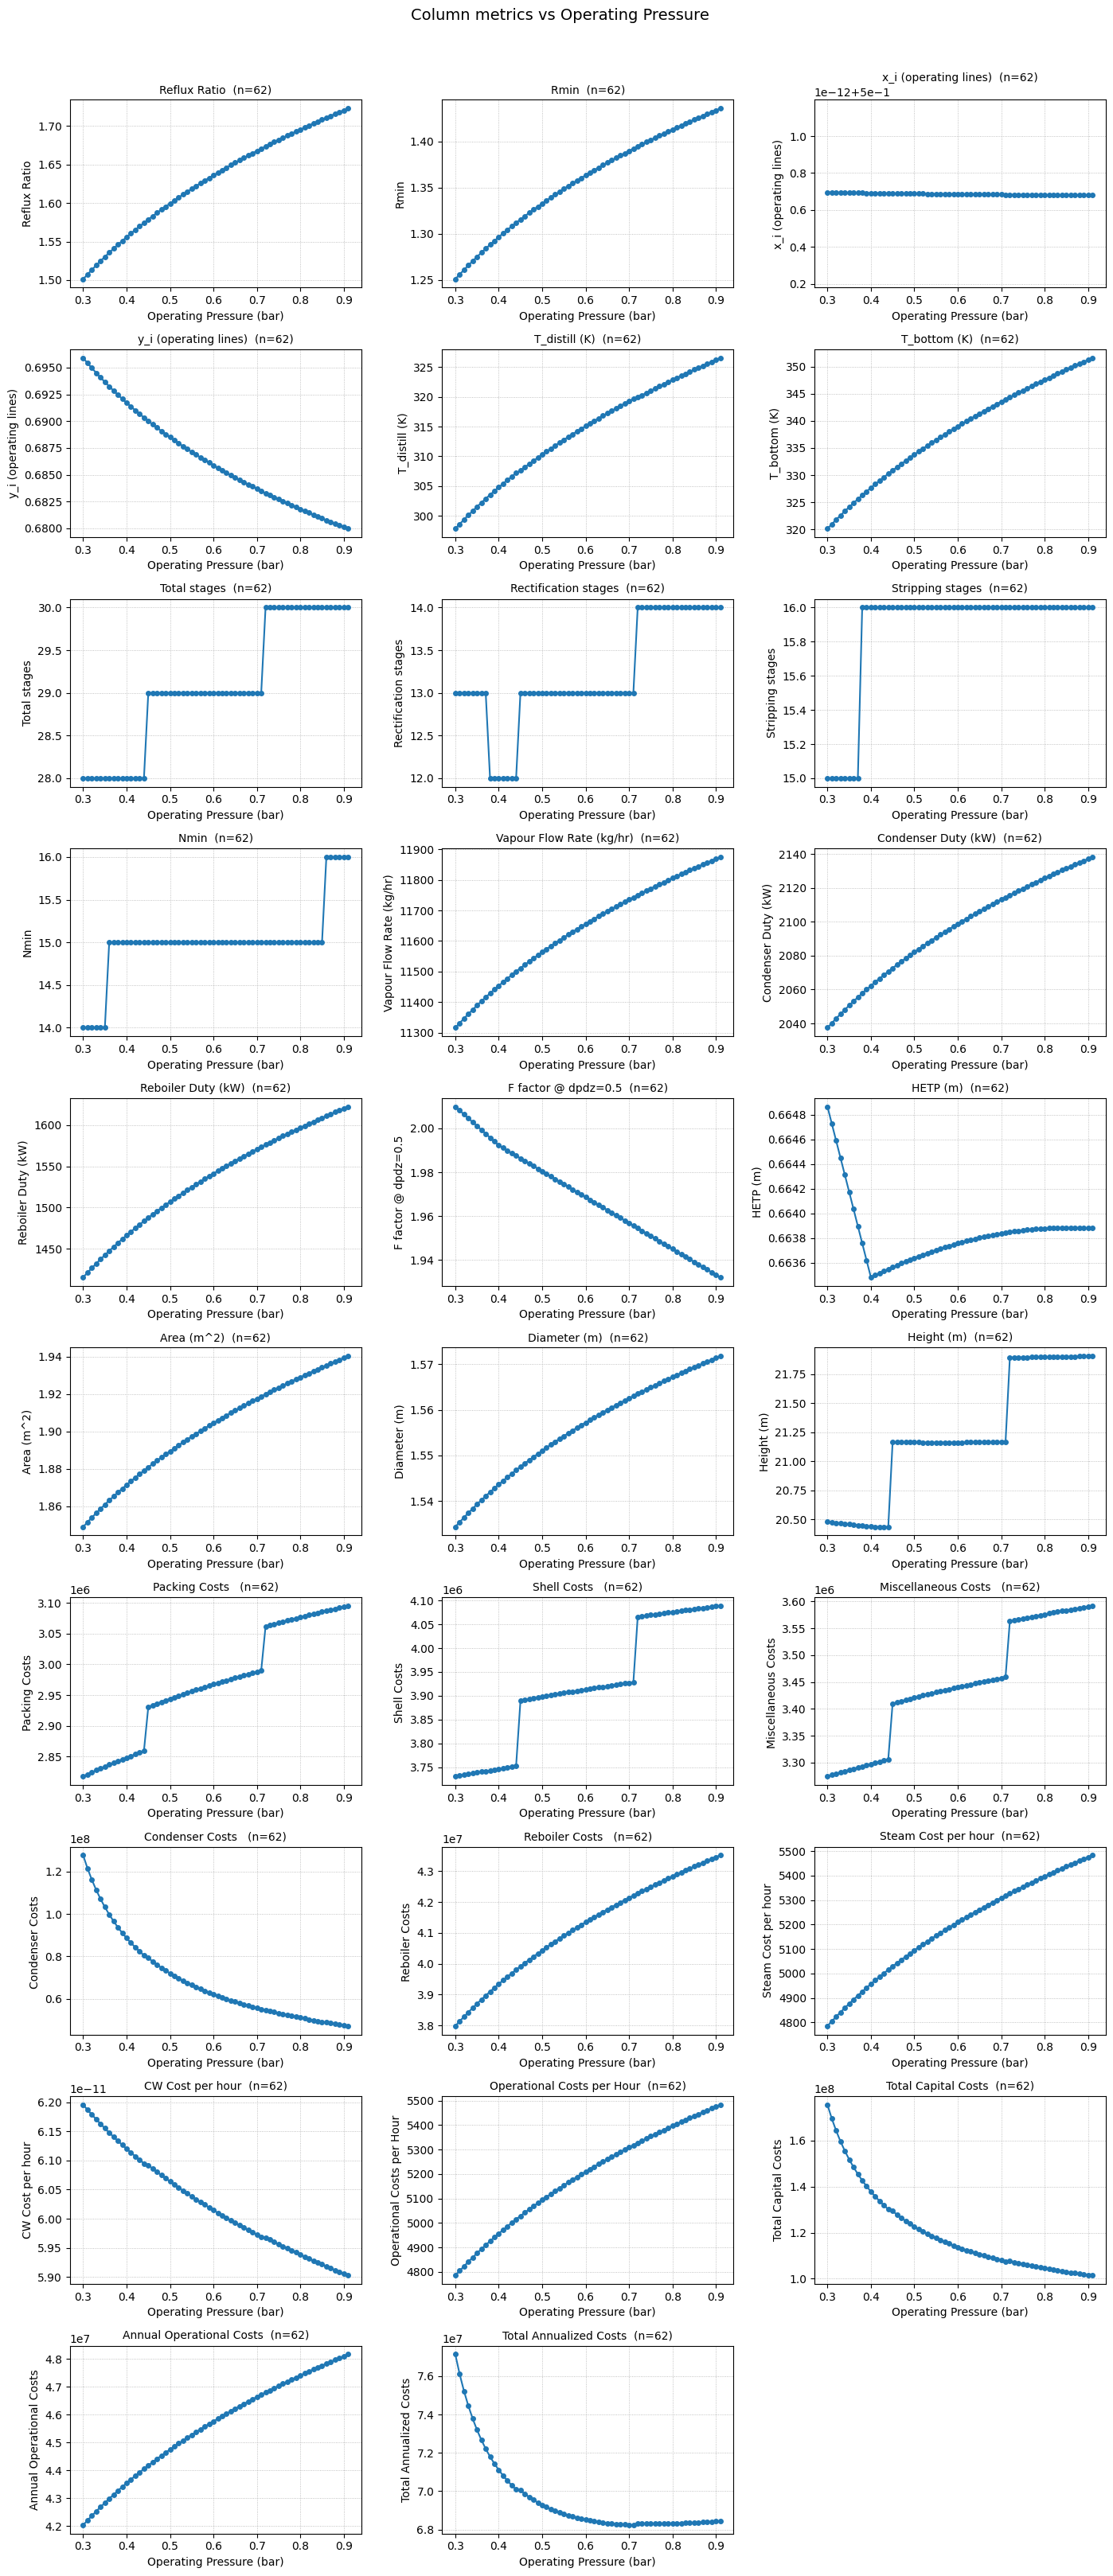

In [ ]:
df = df.sort_values("Operating Pressure").reset_index(drop=True)

def elem(v, i):
    try:
        if isinstance(v, (list, tuple, np.ndarray)):
            return float(v[i]) if len(v) > i else np.nan
        return float(v)
    except Exception:
        return np.nan


df['x_i'] = df['Operating Lines intersection'].apply(lambda v: elem(v, 0))
df['y_i'] = df['Operating Lines intersection'].apply(lambda v: elem(v, 1))

x = df['Operating Pressure'].values

# (column_key, y_label)
plots = [
    ('Reflux Ratio', 'Reflux Ratio'),
    ('Rmin', 'Rmin'),
    ('x_i', 'x_i (operating lines)'),
    ('y_i', 'y_i (operating lines)'),
    ('Temperature of Distill', 'T_distill (K)'),
    ('Temperature of Bottoms', 'T_bottom (K)'),
    ('Total Stages', 'Total stages'),
    ('Rectification Stages', 'Rectification stages'),
    ('Stripping Stages', 'Stripping stages'),
    ('Nmin', 'Nmin'),
    ('Vapour Flow Rate', 'Vapour Flow Rate (kg/hr)'),
    ('Condenser Duty', 'Condenser Duty (kW)'),
    ('Reboiler Duty', 'Reboiler Duty (kW)'),
    ('F Factor @ dpdz=0.5', 'F factor @ dpdz=0.5'),
    ('HETP', 'HETP (m)'),
    ('Area', 'Area (m^2)'),
    ('Diameter', 'Diameter (m)'),
    ('Height', 'Height (m)'),
    ('Packing Costs', 'Packing Costs '),
    ('Shell Costs', 'Shell Costs '),
    ('Miscellaneous Costs', 'Miscellaneous Costs '),
    ('Condenser Costs', 'Condenser Costs '),
    ('Reboiler Costs', 'Reboiler Costs '),
    ("Steam Cost per hour", "Steam Cost per hour"),
    ("CW Cost per hour", "CW Cost per hour"),
    ("Operational Costs per Hour","Operational Costs per Hour"),
    ("Total Capital Costs","Total Capital Costs"),
    ("Annual Operational Costs","Annual Operational Costs"),
    ("Total Annualized Costs","Total Annualized Costs"),
]

# grid layout
n = len(plots)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(14, 3.2 * rows), tight_layout=True)
axes = axes.flatten()

for ax, (col, label) in zip(axes, plots):
    y = df[col].values if col in df.columns else np.full_like(x, np.nan)
    ax.plot(x, y, marker='o', linestyle='-', markersize=4)
    ax.set_xlabel('Operating Pressure (bar)')
    ax.set_ylabel(label)
    ax.grid(True, linestyle=':', linewidth=0.6)
    valid = np.count_nonzero(~pd.isna(y))
    ax.set_title(f"{label}  (n={valid})", fontsize=10)

for ax in axes[n:]:
    ax.axis('off')

plt.suptitle("Column metrics vs Operating Pressure", fontsize=14, y=1.01)
plt.show()


## Optimizing column cost

In [ ]:
def optimize_pressure_total_costs(
    y_equm: callable,
    materialBalance: callable,
    intersections: callable,
    stages: callable,
    compute_energy: callable,
    ColumnEnergyParams,
    f_F: callable,
    f_hetp: callable,
    area: callable,
    height: callable,
    pack_costs: callable,
    shell_costs: callable,
    miscellaneous_costs: callable,
    condenser_cost: callable,
    kettle_reboiler_cost: callable,
    P_bounds: tuple = (0.05, 0.98),   # search bounds in same units you used for Pop (bar)
    F: float = None,
    x_f: float = None,
    D: float = None,
    x_D: float = None,
    B: float = None,
    x_B: float = None,
    q: float = 1,
    maxfun: int = 100
) -> pd.DataFrame:

    matBal = materialBalance(F=F, x_f=x_f, x_D=x_D, x_B=x_B)
    D = matBal['D']; x_D = matBal['x_D']; B = matBal['B']; x_B = matBal['x_B']

    # objective: given Pop (scalar), return TAC (float). Lower is better.
    def objective(Pop_scalar):
        try:
            Pop = float(Pop_scalar)
            inter = intersections(P_T, Pop, q, x_f, x_D)
            Rmin = inter.get("Rmin", None)
            R = inter['RR']
            x_i = inter['x_i']; y_i = inter['y_i']

            Nstages = stages(x_B, x_D, x_i, y_i, Pop)
            Tstage = Nstages['Tstage']
            total = Nstages['total']
            rect = Nstages['rect']
            strip = Nstages['strip']
            Nmin = Nstages.get('Nmin', None)
            xs = Nstages.get('xs', None); ys = Nstages.get('ys', None)

            params = ColumnEnergyParams(F=F, D=D, B=B, q=q, R=R,
                        T_distill = Tstage[-1],
                        T_feed = y_equm(x_f, Pop)[1],
                        T_boil = y_equm(x_f, Pop)[1],
                        T_reboil = Tstage[0])

            energy = compute_energy(params)
            Vflow = energy["Vapour Flow Rate (kg/hr)"]
            condenser_duty = energy["Condenser duty (kW)"]
            reboiler_duty = energy["Reboiler Duty (kW)"]

            Area, Diameter = area(Vflow)
            Height = height(Nstages, f_F, f_hetp, Pop*1000)["Packing height (m)"]
            FFactor = f_F(0.5, Pop*1000)
            HETP = f_hetp(FFactor, Pop*1000)

            pack = pack_costs(Height, Area)
            shell = shell_costs(Height, Diameter, Pop)["Total cost"]
            misc = miscellaneous_costs(pack, shell)
            condenser = condenser_cost(condenser_duty, Tstage[-1], 500)["Total capital"]
            reboiler = kettle_reboiler_cost(reboiler_duty, Tboil_C = Tstage[0])["Total capital"]

            steam_cost = energy["Steam cost (Rs/hr)"]
            cw_cost = energy["CW cost (Rs/hr)"]
            operational_costs = steam_cost + cw_cost
            capital_costs = (pack + shell + misc + condenser + reboiler)

            annual_operational_costs = operational_costs * 24 * 366
            total_annualized_costs = annual_operational_costs + 0.2 * capital_costs

            # return scalar objective
            return float(total_annualized_costs)
        except Exception:
            # penalize infeasible points heavily so optimizer avoids them
            return 1.0e50

    # Run bounded scalar minimizer (Brent/bounded)
    try:
        res = minimize_scalar(objective, bounds=P_bounds, method='bounded', options={'maxiter': maxfun})
    except Exception:
        res = None

    # If minimizer failed or returned non-success, fallback to brute-force grid search
    # if res is None or (hasattr(res, 'success') and not res.success):
    #     Ps = np.linspace(P_bounds[0], P_bounds[1], 101)
    #     vals = [objective(p) for p in Ps]
    #     idx = int(np.nanargmin(vals))
    #     Pop_opt = Ps[idx]
    #     tac_opt = vals[idx]
    # else:
    #     Pop_opt = float(res.x)
    #     tac_opt = float(res.fun)


    inter = intersections(P_T, Pop_opt, q, x_f, x_D)
    Rmin = inter.get("Rmin", None)
    R = inter['RR']
    x_i = inter['x_i']; y_i = inter['y_i']
    Nstages = stages(x_B, x_D, x_i, y_i, Pop_opt)
    Tstage = Nstages['Tstage']
    total = Nstages['total']; rect = Nstages['rect']; strip = Nstages['strip']; Nmin = Nstages.get('Nmin', None)
    xs = Nstages.get('xs', None); ys = Nstages.get('ys', None)
    params = ColumnEnergyParams(F=F, D=D, B=B, q=q, R=R,
                    T_distill = Tstage[-1],
                    T_feed = y_equm(x_f, Pop_opt)[1],
                    T_boil = y_equm(x_f, Pop_opt)[1],
                    T_reboil = Tstage[0])
    energy = compute_energy(params)
    Vflow = energy["Vapour Flow Rate (kg/hr)"]
    condenser_duty = energy["Condenser duty (kW)"]
    reboiler_duty = energy["Reboiler Duty (kW)"]
    Area, Diameter = area(Vflow)
    Height = height(Nstages, f_F, f_hetp, Pop_opt*1000)["Packing height (m)"]
    FFactor = f_F(0.5, Pop_opt*1000)
    HETP = f_hetp(FFactor, Pop_opt*1000)
    pack = pack_costs(Height, Area)
    shell = shell_costs(Height, Diameter, Pop_opt)["Total cost"]
    misc = miscellaneous_costs(pack, shell)
    condenser = condenser_cost(condenser_duty, Tstage[-1], 500)["Total capital"]
    reboiler = kettle_reboiler_cost(reboiler_duty, Tboil_C = Tstage[0])["Total capital"]
    steam_cost = energy["Steam cost (Rs/hr)"]
    cw_cost = energy["CW cost (Rs/hr)"]
    operational_costs = steam_cost + cw_cost
    capital_costs = (pack + shell + misc + condenser + reboiler)
    annual_operational_costs = operational_costs * 24 * 366
    total_annualized_costs = annual_operational_costs + 0.2 * capital_costs

    row = {
        "Operating Pressure": Pop_opt,
        "Reflux Ratio": R,
        "Rmin": Rmin,
        "Operating Lines intersection": [x_i, y_i],
        "Temperature of Distill": Tstage[-1],
        "Temperature of Bottoms": Tstage[0],
        "Vapour Flow Rate": Vflow,
        "Condenser Duty": condenser_duty,
        "Reboiler Duty": reboiler_duty,
        "Total Stages": total,
        "Rectification Stages": rect,
        "Stripping Stages": strip,
        "Nmin": Nmin,
        "xs":xs,
        "ys":ys,
        "Tstage":Tstage,
        "x_i":x_i,
        "y_i":y_i,
        "F Factor @ dpdz=0.5": FFactor,
        "HETP": HETP,
        "Area": Area,
        "Diameter": Diameter,
        "Height": Height,
        "Packing Costs": pack,
        "Shell Costs": shell,
        "Miscellaneous Costs": misc,
        "Condenser Costs": condenser,
        "Reboiler Costs": reboiler,
        "Steam Cost per hour": steam_cost,
        "CW Cost per hour": cw_cost,
        "Operational Costs per Hour": operational_costs,
        "Total Capital Costs": capital_costs,
        "Annual Operational Costs": annual_operational_costs,
        "Total Annualized Costs": total_annualized_costs,
        "Optimization_info": {"method": "minimize_scalar(bounded)", "success": bool(res is not None and getattr(res,'success',True)), "fun": tac_opt}
    }

    return pd.DataFrame([row])


In [ ]:
df_opt = optimize_pressure_total_costs(
    y_equm,
    materialBalance,
    intersections,
    stages,
    compute_energy,
    ColumnEnergyParams,
    f_F,
    f_hetp,
    area,
    height,
    pack_costs,
    shell_costs,
    miscellaneous_costs,
    condenser_cost,
    kettle_reboiler_cost,
    P_bounds=(0.05, 0.98),
    F=5000,
    x_f=0.5,
    D=None,
    x_D=0.99,
    B=None,
    x_B=0.0001,
    q=1
)

print("Optimizer result:")
print(df_opt.T)

Optimizer result:
                                                                              0
Operating Pressure                                                     0.718376
Reflux Ratio                                                           1.672975
Rmin                                                                   1.394146
Operating Lines intersection            [0.5000000000006833, 0.683316348971255]
Temperature of Distill                                               319.991646
Temperature of Bottoms                                               344.327869
Vapour Flow Rate                                                   11749.268379
Condenser Duty                                                      2115.521045
Reboiler Duty                                                       1575.669608
Total Stages                                                                 29
Rectification Stages                                                         13
Stripping Stages      

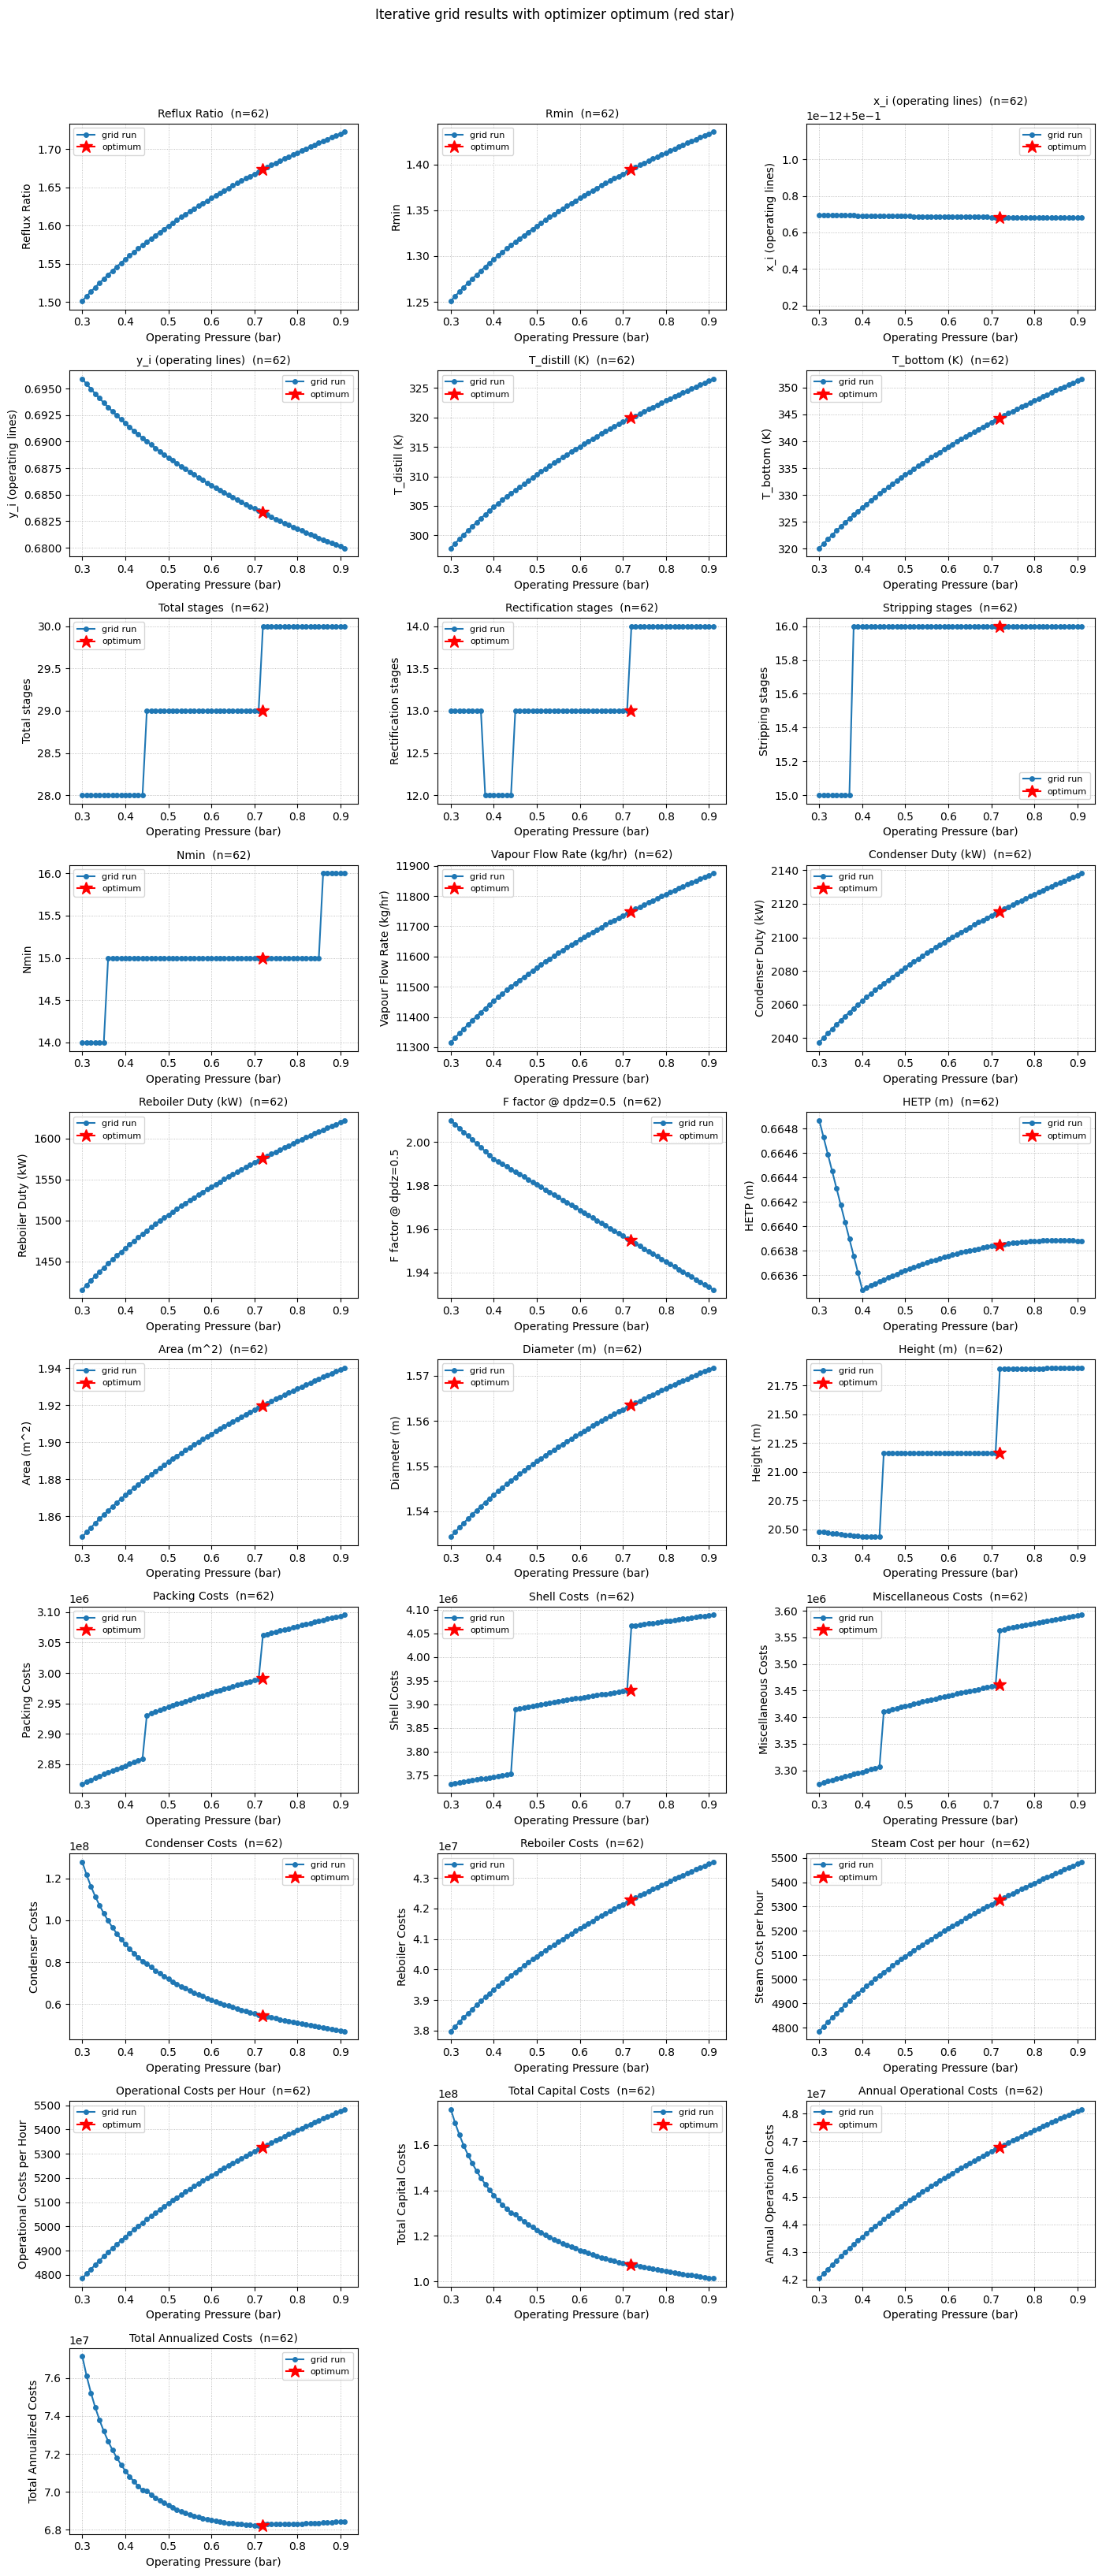

In [ ]:
def _get_elem(v, i=0):
    try:
        if isinstance(v, (list, tuple, np.ndarray)):
            return float(v[i]) if len(v) > i else np.nan
        return float(v)
    except Exception:
        return np.nan

if 'x_i' not in df.columns or 'y_i' not in df.columns:
    if 'Operating Lines intersection' in df.columns:
        df['x_i'] = df['Operating Lines intersection'].apply(lambda v: _get_elem(v, 0))
        df['y_i'] = df['Operating Lines intersection'].apply(lambda v: _get_elem(v, 1))
    else:
        df['x_i'] = np.nan
        df['y_i'] = np.nan

if 'x_i' not in df_opt.columns or 'y_i' not in df_opt.columns:
    if 'Operating Lines intersection' in df_opt.columns:
        df_opt['x_i'] = df_opt['Operating Lines intersection'].apply(lambda v: _get_elem(v, 0))
        df_opt['y_i'] = df_opt['Operating Lines intersection'].apply(lambda v: _get_elem(v, 1))
    else:
        df_opt['x_i'] = np.nan
        df_opt['y_i'] = np.nan

plots = [
    ('Reflux Ratio', 'Reflux Ratio'),
    ('Rmin', 'Rmin'),
    ('x_i', 'x_i (operating lines)'),
    ('y_i', 'y_i (operating lines)'),
    ('Temperature of Distill', 'T_distill (K)'),
    ('Temperature of Bottoms', 'T_bottom (K)'),
    ('Total Stages', 'Total stages'),
    ('Rectification Stages', 'Rectification stages'),
    ('Stripping Stages', 'Stripping stages'),
    ('Nmin', 'Nmin'),
    ('Vapour Flow Rate', 'Vapour Flow Rate (kg/hr)'),
    ('Condenser Duty', 'Condenser Duty (kW)'),
    ('Reboiler Duty', 'Reboiler Duty (kW)'),
    ('F Factor @ dpdz=0.5', 'F factor @ dpdz=0.5'),
    ('HETP', 'HETP (m)'),
    ('Area', 'Area (m^2)'),
    ('Diameter', 'Diameter (m)'),
    ('Height', 'Height (m)'),
    ('Packing Costs', 'Packing Costs'),
    ('Shell Costs', 'Shell Costs'),
    ('Miscellaneous Costs', 'Miscellaneous Costs'),
    ('Condenser Costs', 'Condenser Costs'),
    ('Reboiler Costs', 'Reboiler Costs'),
    ("Steam Cost per hour", "Steam Cost per hour"),
    ("Operational Costs per Hour","Operational Costs per Hour"),
    ("Total Capital Costs","Total Capital Costs"),
    ("Annual Operational Costs","Annual Operational Costs"),
    ("Total Annualized Costs","Total Annualized Costs"),
]

x = df['Operating Pressure'].values
n = len(plots)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(14, 3.2 * rows), tight_layout=True)
axes = axes.flatten()

Pop_opt = float(df_opt['Operating Pressure'].iloc[0])

for ax, (col, label) in zip(axes, plots):
    if col in df.columns:
        y = df[col].values
    else:
        y = np.full_like(x, np.nan, dtype=float)

    ax.plot(x, y, marker='o', linestyle='-', markersize=4, label='grid run')
    ax.set_xlabel('Operating Pressure (bar)')
    ax.set_ylabel(label)
    ax.grid(True, linestyle=':', linewidth=0.6)
    valid = np.count_nonzero(~pd.isna(y))
    ax.set_title(f"{label}  (n={valid})", fontsize=10)

    y_opt = None
    if col in df_opt.columns:
        try:
            y_opt = float(df_opt[col].iloc[0])
        except Exception:
            y_opt = _get_elem(df_opt[col].iloc[0], 0)
    else:
        # try derived columns mapping
        if col == 'x_i':
            y_opt = float(df_opt['x_i'].iloc[0])
        elif col == 'y_i':
            y_opt = float(df_opt['y_i'].iloc[0])
        else:
            y_opt = None

    if y_opt is not None and np.isfinite(y_opt):
        ax.plot(Pop_opt, y_opt, marker='*', color='red', markersize=12, label='optimum')
    ax.legend(fontsize=8)

for ax in axes[n:]:
    ax.axis('off')

plt.suptitle("Iterative grid results with optimizer optimum (red star)", fontsize=12, y=1.02)
plt.show()


In [ ]:
df_opt["xs"],df_opt["ys"],df_opt["Tstage"]

(0    [0.0001, 0.0001, 0.0002444745669829551, 0.0002...
 Name: xs, dtype: object,
 0    [0.0001, 0.0002974542631989067, 0.000297454263...
 Name: ys, dtype: object,
 0    [344.3278690722324, 344.3278690722324, 344.319...
 Name: Tstage, dtype: object)

In [ ]:
df_opt["x_i"],df_opt["y_i"]

(0    0.5
 Name: x_i, dtype: float64,
 0    0.683316
 Name: y_i, dtype: float64)

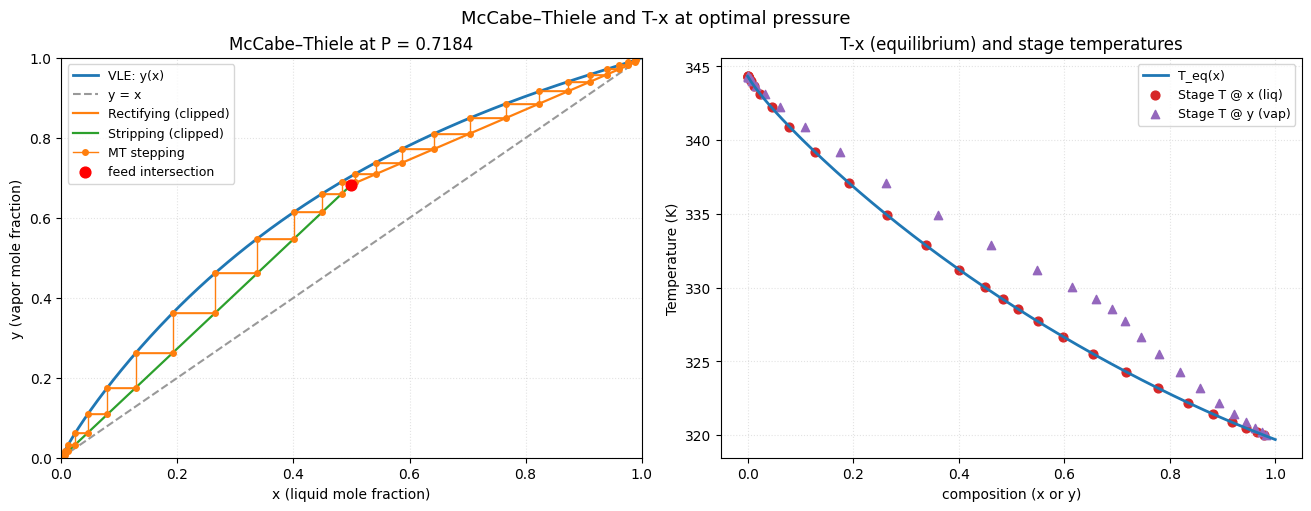

In [ ]:
Pop_opt = float(df_opt['Operating Pressure'].iloc[0])
R_opt = float(df_opt['Reflux Ratio'].iloc[0])
x_i = float(df_opt['x_i'].iloc[0])
y_i = float(df_opt['y_i'].iloc[0])

x_D = df_opt.get('x_D', pd.Series([0.99])).iloc[0] if 'x_D' in df_opt.columns else 0.99
x_B = df_opt.get('x_B', pd.Series([0.0001])).iloc[0] if 'x_B' in df_opt.columns else 0.0001

xs_raw = list(df_opt['xs'].iloc[0]) if 'xs' in df_opt.columns else []
ys_raw = list(df_opt['ys'].iloc[0]) if 'ys' in df_opt.columns else []
Tstage_raw = list(df_opt['Tstage'].iloc[0]) if 'Tstage' in df_opt.columns else []

def compact_consecutive(lst):
    out = []
    for v in lst:
        try:
            vv = float(v)
        except Exception:
            continue
        if len(out) == 0 or not np.isclose(vv, out[-1], rtol=1e-6, atol=1e-9):
            out.append(vv)
    return out

xs_stored = compact_consecutive(xs_raw)
ys_stored = compact_consecutive(ys_raw)
Tstage_stored = compact_consecutive(Tstage_raw)

minlen = min(len(xs_stored), len(ys_stored), len(Tstage_stored)) if len(xs_stored) and len(ys_stored) and len(Tstage_stored) else 0
if minlen > 0:
    xs_stored = xs_stored[:minlen]
    ys_stored = ys_stored[:minlen]
    Tstage_stored = Tstage_stored[:minlen]

x_grid = np.linspace(0.0, 1.0, 301)
y_grid = np.full_like(x_grid, np.nan)
T_grid = np.full_like(x_grid, np.nan)
for i, xv in enumerate(x_grid):
    try:
        yv, Tv = y_equm(xv, Pop_opt)
        y_grid[i] = float(yv)
        T_grid[i] = float(Tv)
    except Exception:
        y_grid[i] = np.nan
        T_grid[i] = np.nan

# rectifying: domain [x_i, x_D]
x_rect = np.linspace(x_i, x_D, 101)
y_rect = (R_opt / (R_opt + 1.0)) * x_rect + x_D / (R_opt + 1.0)
# stripping: domain [x_B, x_i]
x_strip = np.linspace(x_B, x_i, 101)
slope_strip = (y_i - x_B) / (x_i - x_B) if (x_i - x_B) != 0 else 0.0
y_strip = slope_strip * (x_strip - x_B) + x_B

def build_MT_steps(xB, xD, xi, yi, Pop, y_equm_func, R, max_steps=200):
    steps_x = []
    steps_y = []
    x = xB
    steps = 0

    while x < xD - 1e-8 and steps < max_steps:
        try:
            y_eq, Ttmp = y_equm_func(x, Pop)
            y_eq = float(y_eq)
        except Exception:
            break
        steps_x.append(x)
        steps_y.append(y_eq)
        if x < xi:
            if slope_strip == 0:
                break
            x_next = (y_eq - x_B) / slope_strip + x_B
        else:
            x_next = (y_eq - x_D / (R + 1.0)) * (R + 1.0) / R if R != 0 else xD
        x_next = max(min(x_next, xD), xB)
        steps_x.append(x_next)
        steps_y.append(y_eq)
        x = x_next
        steps += 1
        if len(steps_x) >= 4 and np.isclose(steps_x[-1], steps_x[-3], atol=1e-9):
            break
    return np.array(steps_x), np.array(steps_y)

mt_x, mt_y = build_MT_steps(x_B, x_D, x_i, y_i, Pop_opt, y_equm, R_opt, max_steps=400)

fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)

ax = axes[0]
ax.plot(x_grid, y_grid, lw=2, label='VLE: y(x)')
ax.plot(x_grid, x_grid, '--', color='0.6', label='y = x')

ax.plot(x_rect, y_rect, color='C1', lw=1.6, label='Rectifying (clipped)')
ax.plot(x_strip, y_strip, color='C2', lw=1.6, label='Stripping (clipped)')

if mt_x.size > 0:
    for i in range(0, len(mt_x)-1, 2):
        x_v = [mt_x[i], mt_x[i]]
        y_v = [mt_y[i], mt_y[i]]
        ax.plot(x_v, y_v, color='tab:orange', lw=1.2)
        x_h = [mt_x[i], mt_x[i+1]]
        y_h = [mt_y[i], mt_y[i+1]]
        ax.plot(x_h, y_h, color='tab:orange', lw=1.2)
    ax.plot(mt_x, mt_y, color='tab:orange', lw=1.0, marker='o', markersize=4, label='MT stepping')

ax.scatter([x_i], [y_i], color='red', s=60, zorder=6, label='feed intersection')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('x (liquid mole fraction)')
ax.set_ylabel('y (vapor mole fraction)')
ax.set_title(f"McCabe–Thiele at P = {Pop_opt:.4f}")
ax.grid(alpha=0.35, linestyle=':')
ax.legend(fontsize=9)

ax2 = axes[1]
ax2.plot(x_grid, T_grid, lw=2, label='T_eq(x)')
if len(Tstage_stored):
    if len(xs_stored) == len(Tstage_stored):
        ax2.scatter(xs_stored, Tstage_stored, color='tab:red', s=40, marker='o', label='Stage T @ x (liq)')
        ax2.scatter(ys_stored, Tstage_stored, color='tab:purple', s=36, marker='^', label='Stage T @ y (vap)')
    else:
        T_at_mt = []
        for xv in mt_x:
            try:
                _, Tv = y_equm(xv, Pop_opt)
                T_at_mt.append(float(Tv))
            except Exception:
                T_at_mt.append(np.nan)
        ax2.scatter(mt_x, T_at_mt, color='tab:red', s=40, marker='o', label='Stage T (estimated)')

ax2.set_xlabel('composition (x or y)')
ax2.set_ylabel('Temperature (K)')
ax2.set_title('T-x (equilibrium) and stage temperatures')
ax2.grid(alpha=0.35, linestyle=':')
ax2.legend(fontsize=9)

plt.suptitle('McCabe–Thiele and T-x at optimal pressure', fontsize=13)
plt.show()
